# Main Program for Capital One Data Challenge
Author: Harsh Alang\
Project Submission Date: August 28th, 2022

In [1]:
import pandas as pd
import numpy as np
import functions
from importlib import reload
reload(functions)
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.io as io

import matplotlib.pyplot as plt


flights = functions.load_data_file("Flights.csv")
tickets = functions.load_data_file("Tickets.csv")
airport = functions.load_data_file("Airport_Codes.csv")

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print (functions.summary_statistics(flights),"\n", functions.summary_statistics(tickets), "\n", functions.summary_statistics(airport))

(FL_DATE              1915886
OP_CARRIER           1915886
TAIL_NUM             1903730
OP_CARRIER_FL_NUM    1915886
ORIGIN_AIRPORT_ID    1915886
ORIGIN               1915886
ORIGIN_CITY_NAME     1915886
DEST_AIRPORT_ID      1915886
DESTINATION          1915886
DEST_CITY_NAME       1915886
DEP_DELAY            1865535
ARR_DELAY            1859895
CANCELLED            1915886
AIR_TIME             1859335
DISTANCE             1915256
OCCUPANCY_RATE       1915576
dtype: int64, FL_DATE               object
OP_CARRIER            object
TAIL_NUM              object
OP_CARRIER_FL_NUM     object
ORIGIN_AIRPORT_ID     object
ORIGIN                object
ORIGIN_CITY_NAME      object
DEST_AIRPORT_ID       object
DESTINATION           object
DEST_CITY_NAME        object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
AIR_TIME              object
DISTANCE              object
OCCUPANCY_RATE       float64
dtype: object,        DEP_DELAY  ARR_DELAY  CANCELLED  OC

In [3]:
functions.to_number(flights,["DISTANCE","AIR_TIME"])
functions.to_number(tickets,["ITIN_FARE"])

## Next step creates histograms to make sure all numeric fields are captured correctly
## Note:Hist function creates histogram on only numeric fields
## Note: The output from below function will create interactive graphs, but we will change interactive graphs to
## pdf to ensure file size is manageable
## 

functions.hist(flights,"flights")
functions.hist(tickets,"tickets")
functions.hist(airport,"airport")

-38.0
202.0
-15.0
200.0
0.0
944.0
(FL_DATE              1915886
OP_CARRIER           1915886
TAIL_NUM             1915886
OP_CARRIER_FL_NUM    1915886
ORIGIN_AIRPORT_ID    1915886
ORIGIN               1915886
ORIGIN_CITY_NAME     1915886
DEST_AIRPORT_ID      1915886
DESTINATION          1915886
DEST_CITY_NAME       1915886
DEP_DELAY            1915886
ARR_DELAY            1915886
CANCELLED            1915886
AIR_TIME             1915886
DISTANCE             1915886
OCCUPANCY_RATE       1915886
dtype: int64, FL_DATE               object
OP_CARRIER            object
TAIL_NUM              object
OP_CARRIER_FL_NUM     object
ORIGIN_AIRPORT_ID     object
ORIGIN                object
ORIGIN_CITY_NAME      object
DEST_AIRPORT_ID       object
DESTINATION           object
DEST_CITY_NAME        object
DEP_DELAY            float64
ARR_DELAY            float64
CANCELLED            float64
AIR_TIME             float64
DISTANCE             float64
OCCUPANCY_RATE       float64
dtype: object,        D

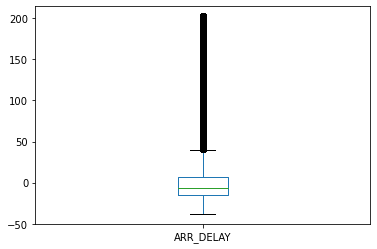

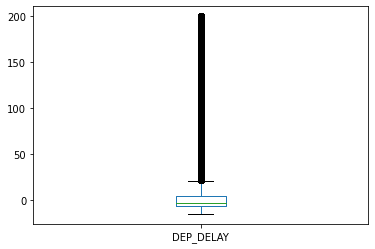

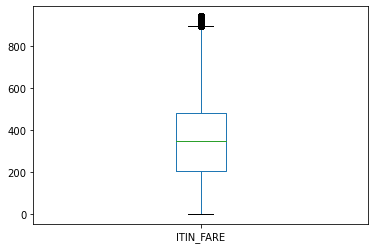

In [4]:
"""After looking at the histogram of the flights dataset, we can say that ARR_DELAY and DEP_DELAY have
large number of outliers,
while these are interesting data points, for our data analysis we will remove any data points outside the 
1 - 99 percentile range and replace them with the median.
To calculate most profitable round trip routes, we will use flights_ds after removing the outliers.
We will also use the same approach to clean Fare information from the tickets dataset, as this variable will be
used for revenue calculation. We will use slightly narrower population - 1 to 95 percentile range."""


    
flights = functions.remove_outliers(flights,['ARR_DELAY','DEP_DELAY'],.01,.99)
tickets = functions.remove_outliers(tickets,['ITIN_FARE'],.01,.95)


print (functions.summary_statistics(flights),"\n", functions.summary_statistics(tickets), "\n", functions.summary_statistics(airport))

# To limit size of the files created, output of the following was merged and one pdf file titled "Histograms.pdf" was created
functions.boxplot(flights,"ARR_DELAY")
functions.boxplot(flights,"DEP_DELAY")
functions.boxplot(tickets,"ITIN_FARE")

In [5]:
""" After exploring data fields in the flights and tickets dataset, we can say for certain that there are no clear key 
fields that links the 2 tables, as initial join using  led to cartesian.
We will group tickets and flights datasets independently and then will join them based on Origin & Destination

"""
f_summary = flights.query("CANCELLED == 0").groupby(['ORIGIN','DESTINATION']).count()

f_summary.reset_index(inplace=True)
f_summary = f_summary[['ORIGIN','DESTINATION','FL_DATE']].rename(columns={'FL_DATE':'FLIGHT_COUNT'})


#f_summary.rename(columns={'FL_DATE':'FLIGHT_COUNT'})

In [8]:
"""Summarize tickets dataset by ORIGIN & DESTINATION and calculate percentage of passengers that book a round trip 
for a given route.
For 1st problem, since we are asked to find busiest round trips, we will first find busiest routes and then 
multiply with 'ROUNDTRIP_RATE' (% of ROUND_TRIPS based on data from tickets"""
#Using histograms we noticed that some routes had outliers, to address that we will use the median value instead of
#the average value. Median will be calculated using the quantile 0.50"""



t_summary = tickets.query("ROUNDTRIP == 1").groupby(['ORIGIN','DESTINATION']).aggregate({'PASSENGERS':'sum',\
                                                                                         'ITIN_FARE': functions.q50,
                                                                                         'ITIN_ID':'count'})

t_summary.reset_index(inplace=True)

t_summary1 = tickets.groupby(['ORIGIN','DESTINATION']).aggregate({'PASSENGERS':'sum'})
t_summary1.reset_index(inplace=True)

round_trip_rate = pd.merge(t_summary, t_summary1,on=['ORIGIN','DESTINATION'],how='inner').\
assign(ROUNDTRIP_RATE = lambda x:(x['PASSENGERS_x']/x['PASSENGERS_y']))

### Multiply "ROUNDTRIP_RATE" to the total # of flights calculated from the flights table

solution_1 = pd.merge(f_summary,round_trip_rate, how='inner', on =['ORIGIN','DESTINATION']).\
assign(FLIGHT_COUNT_FL = lambda x:(x['FLIGHT_COUNT']* x['ROUNDTRIP_RATE']))

busiest_round_trips = solution_1[['ORIGIN','DESTINATION','FLIGHT_COUNT_FL']].round()


# Solution 1: 10 Busiest Round Trip Routes

In [9]:
print (busiest_round_trips.sort_values(by=['FLIGHT_COUNT_FL'], ascending=False).head(10))
#busiest_round_trips.sort_values(by=['FLIGHT_COUNT_FL'], ascending=False).head(10).to_excel('Solution_1.xlsx')

     ORIGIN DESTINATION  FLIGHT_COUNT_FL
3993    ORD         LGA          2207.00
3058    LGA         ORD          2007.00
5176    SFO         LAX          1973.00
2916    LAX         LAS          1796.00
5050    SEA         PDX          1706.00
3009    LGA         ATL          1642.00
2954    LAX         SFO          1611.00
2693    JFK         LAX          1603.00
197     ATL         MCO          1597.00
5032    SEA         LAX          1553.00


In [10]:
""" Tried to merge pandas airport and flights datasets by the available fields, but the count of the final dataset
    indicated that we should add another key field, so creating ORIGIN_CITY from the ORIGIN_CITY_NAME"""

flights[['ORIGIN_CITY','ORIGIN_STATE']] = flights['ORIGIN_CITY_NAME'].str.split(',', expand=True)
#print(flights_ds)

flights_summary_v1 = pd.merge(flights,airport[['IATA_CODE','TYPE','MUNICIPALITY']], how='inner',\
                              left_on=['ORIGIN','ORIGIN_CITY'], right_on =['IATA_CODE','MUNICIPALITY'])

print(flights_summary_v1.count())

FL_DATE              1757587
OP_CARRIER           1757587
TAIL_NUM             1757587
OP_CARRIER_FL_NUM    1757587
ORIGIN_AIRPORT_ID    1757587
ORIGIN               1757587
ORIGIN_CITY_NAME     1757587
DEST_AIRPORT_ID      1757587
DESTINATION          1757587
DEST_CITY_NAME       1757587
DEP_DELAY            1757587
ARR_DELAY            1757587
CANCELLED            1757587
AIR_TIME             1757587
DISTANCE             1757587
OCCUPANCY_RATE       1757587
ORIGIN_CITY          1757587
ORIGIN_STATE         1757587
IATA_CODE            1757587
TYPE                 1757587
MUNICIPALITY         1757587
dtype: int64


In [11]:
flights_summary_v1['ARR_DELAY_COSTS']= flights_summary_v1['ARR_DELAY'].apply(functions.delay_costs)
flights_summary_v1['DEP_DELAY_COSTS']= flights_summary_v1['DEP_DELAY'].apply(functions.delay_costs)
flights_summary_v1['AIRPORT_COSTS'] = flights_summary_v1['TYPE'].apply(functions.airport_costs)
flights_summary_v1['COSTS_PER_MILE']= flights_summary_v1['DISTANCE'].apply(functions.costs_per_mile)
flights_summary_v1['NO_OF_PASSENGERS']= flights_summary_v1['OCCUPANCY_RATE'].apply(functions.number_of_passengers)



#flights_costs = flights_summary_v1[['NO_OF_PASSENGERS', 'ARR_DELAY_COSTS','DEP_DELAY', 'DEP_DELAY_COSTS','AIRPORT_COSTS','TYPE',\
#                          'COSTS_PER_MILE','DISTANCE','OCCUPANCY_RATE','CANCELLED']]

flights_summary_v1['TOTAL_COSTS']= (flights_summary_v1['ARR_DELAY_COSTS']+flights_summary_v1['AIRPORT_COSTS']+\
                    flights_summary_v1['DEP_DELAY_COSTS']+flights_summary_v1['COSTS_PER_MILE'])*2

flight_costs_rev = flights_summary_v1.query("CANCELLED == 0").groupby(['ORIGIN','DESTINATION','TYPE']).\
                       aggregate({'FL_DATE':'count','NO_OF_PASSENGERS':'sum','TOTAL_COSTS':'sum','AIR_TIME':'mean',
                                 'ARR_DELAY':'mean','DEP_DELAY':'mean','OCCUPANCY_RATE':'mean'})

flight_costs_rev.reset_index(inplace=True)


print (flight_costs_rev.head(10))

  ORIGIN DESTINATION            TYPE  FL_DATE  NO_OF_PASSENGERS  TOTAL_COSTS  \
0    ABI         DFW  medium_airport      487          64216.00   7066478.56   
1    ABQ         ATL   large_airport      165          21348.00   7183458.60   
2    ABQ         AUS   large_airport       70           8864.00   2273088.80   
3    ABQ         BWI   large_airport       85          10836.00   4381352.00   
4    ABQ         DAL   large_airport      408          53976.00  12998660.40   
5    ABQ         DEN   large_airport      574          74736.00  16095635.36   
6    ABQ         DFW   large_airport      953         125264.01  30602688.52   
7    ABQ         HOU   large_airport      243          31208.00   8414113.32   
8    ABQ         IAH   large_airport      384          50218.00  13585078.56   
9    ABQ         JFK   large_airport       60           7474.00   3427821.60   

   AIR_TIME  ARR_DELAY  DEP_DELAY  OCCUPANCY_RATE  
0     34.22       4.47       2.86            0.66  
1    145.32    

In [12]:
flight_costs_rev = flight_costs_rev.rename(columns={'FL_DATE':'FLIGHTS_COUNT'})
t_summary = t_summary.rename(columns={'ITIN_FARE':'ITIN_FARE_MEDIAN'})
## we will have to address outliers in the tickets dataset, we already made sure that outliers outside 0.1 and .95 
## range were removed.
## now we will make sure that we have multiple datapoints for FARE for a given route 
## and calculate median on that route



#print (t_origin_destination.columns)
print (t_summary.columns)
print (t_summary1.columns)


costs_rev_ds = pd.merge(flight_costs_rev, t_summary, how='inner', on=['ORIGIN','DESTINATION'])

Index(['ORIGIN', 'DESTINATION', 'PASSENGERS', 'ITIN_FARE_MEDIAN', 'ITIN_ID'], dtype='object')
Index(['ORIGIN', 'DESTINATION', 'PASSENGERS'], dtype='object')


In [13]:
## Next we will calculate cost per round trip
costs_rev_ds = costs_rev_ds.assign(COST_PER_ROUND_TRIP = lambda x:(x['TOTAL_COSTS']/(x['FLIGHTS_COUNT'])))
print (costs_rev_ds.columns)

Index(['ORIGIN', 'DESTINATION', 'TYPE', 'FLIGHTS_COUNT', 'NO_OF_PASSENGERS',
       'TOTAL_COSTS', 'AIR_TIME', 'ARR_DELAY', 'DEP_DELAY', 'OCCUPANCY_RATE',
       'PASSENGERS', 'ITIN_FARE_MEDIAN', 'ITIN_ID', 'COST_PER_ROUND_TRIP'],
      dtype='object')


In [14]:
## Calculate fields to calculate revenue
## since we include only round_trip == 1 records for tickets dataset, we dont need to multiply the fare *2
## we divide number of passengers by flight count to estimate the number of passengers per flight and multiply by 
## average fare charged(round trip only)
costs_rev_ds = costs_rev_ds.assign(REV_TICKETS_PER_ROUND_TRIP = \
                    lambda x: ( ((x['NO_OF_PASSENGERS']/x['FLIGHTS_COUNT'])*x['ITIN_FARE_MEDIAN'])  ))

##next we calculate revenue by tickets sold
costs_rev_ds = costs_rev_ds.assign(REV_BAGGAGE_PER_ROUND_TRIP = \
                                   lambda x: ((x['NO_OF_PASSENGERS']/x['FLIGHTS_COUNT'])*35)
                                  )
costs_rev_ds = costs_rev_ds.assign(REVENUE =lambda x: (\
                           (x['REV_TICKETS_PER_ROUND_TRIP'] + x['REV_BAGGAGE_PER_ROUND_TRIP']) ))
costs_rev_ds = costs_rev_ds.assign(PROFIT= lambda x: ( \
                                    (x['REV_TICKETS_PER_ROUND_TRIP'] + x['REV_BAGGAGE_PER_ROUND_TRIP']) - \
                                                      x['COST_PER_ROUND_TRIP'])
                                  )
costs_rev_ds = costs_rev_ds.assign(PROFIT_MARGIN =lambda x: (\
                           x['PROFIT']/ (x['REV_TICKETS_PER_ROUND_TRIP'] + x['REV_BAGGAGE_PER_ROUND_TRIP']) ))

print(costs_rev_ds.columns)

Index(['ORIGIN', 'DESTINATION', 'TYPE', 'FLIGHTS_COUNT', 'NO_OF_PASSENGERS',
       'TOTAL_COSTS', 'AIR_TIME', 'ARR_DELAY', 'DEP_DELAY', 'OCCUPANCY_RATE',
       'PASSENGERS', 'ITIN_FARE_MEDIAN', 'ITIN_ID', 'COST_PER_ROUND_TRIP',
       'REV_TICKETS_PER_ROUND_TRIP', 'REV_BAGGAGE_PER_ROUND_TRIP', 'REVENUE',
       'PROFIT', 'PROFIT_MARGIN'],
      dtype='object')


# Solution 2: 10 Most Profitable Round Trip Routes

In [15]:
## we add ITIN> 4 to make sure we have few data points from the tickets sample dataset about fare for a given route, 
## it's
## not safe to make decision based on 1 data point, we are considering minimum as 5 to make decision confidently
print (costs_rev_ds\
       [['ORIGIN','DESTINATION','TYPE','ITIN_ID','ARR_DELAY','DEP_DELAY','AIR_TIME','OCCUPANCY_RATE',\
         'ITIN_FARE_MEDIAN','COST_PER_ROUND_TRIP',\
         'REV_TICKETS_PER_ROUND_TRIP','FLIGHTS_COUNT',\
         'REV_BAGGAGE_PER_ROUND_TRIP',\
         'REVENUE',\
         'PROFIT','PROFIT_MARGIN']].query("ITIN_ID >4")\
       .sort_values(by=['PROFIT'], ascending=False).head(10))

     ORIGIN DESTINATION            TYPE  ITIN_ID  ARR_DELAY  DEP_DELAY  \
1460    DTW         DAY   large_airport        6      -0.95      11.00   
4891    STX         ATL  medium_airport        6      -1.48       4.97   
2016    HVN         PHL  medium_airport       10       1.78       4.78   
166     ATL         GTR   large_airport        5      -2.30       4.32   
2223    ILM         CLT  medium_airport        8      -3.33       2.82   
4419    SCC         ANC  medium_airport       76      -9.03      -0.84   
88      ANC         SCC   large_airport       24      -7.20       0.38   
1323    DEN         ISN   large_airport        5       7.07      12.81   
1684    EYW         DFW  medium_airport        5      19.77      17.70   
4099    RAP         ORD  medium_airport        5       9.00      13.86   

      AIR_TIME  OCCUPANCY_RATE  ITIN_FARE_MEDIAN  COST_PER_ROUND_TRIP  \
1460     33.75            0.65            848.50             25915.61   
4891    224.85            0.66         

# For Solution 3
I would like to understand how various factors like Arrival/Departure delays,occupancy rates, air time can affect our Profit Margins. I would also like to see if there is a relationship btw arrival/departure delays with the airport type. and if profit margins are impacted by air time, and other factors

In [16]:
## Graphs.html was created initially but due to memory issue file format was changed to pdf
with open("Graphs.html",'w') as f:


    functions.graphs(px.box,costs_rev_ds,'TYPE','ARR_DELAY')
    functions.graphs(px.box, costs_rev_ds,'TYPE', 'DEP_DELAY')
    functions.graphs(px.scatter, costs_rev_ds.loc[costs_rev_ds['PROFIT_MARGIN']>0], 'AIR_TIME','PROFIT_MARGIN')
    functions.graphs(px.scatter, costs_rev_ds.loc[costs_rev_ds['PROFIT_MARGIN']>0], 'PROFIT_MARGIN','ARR_DELAY')
    functions.graphs(px.scatter, costs_rev_ds.loc[costs_rev_ds['PROFIT_MARGIN']>0], 'PROFIT_MARGIN','DEP_DELAY')

    functions.graphs(px.box,costs_rev_ds,'TYPE','PROFIT_MARGIN')
    functions.graphs(px.box,costs_rev_ds,'TYPE','OCCUPANCY_RATE')
    functions.graphs(px.scatter, costs_rev_ds.loc[costs_rev_ds['PROFIT_MARGIN']>0],'PROFIT_MARGIN','OCCUPANCY_RATE')
    functions.graphs(px.scatter, costs_rev_ds.loc[costs_rev_ds['PROFIT_MARGIN']>0], 'FLIGHTS_COUNT','PROFIT_MARGIN')
    functions.graphs(px.scatter, costs_rev_ds, x='ITIN_FARE_MEDIAN',y='OCCUPANCY_RATE')

# Solution 3: 5 Recommended Round Trip Routes based on above factors

In [17]:
print (costs_rev_ds.query("TYPE == 'medium_airport' & AIR_TIME < 100 &  PROFIT_MARGIN > 0.80")\
      .sort_values(by=['PROFIT','PROFIT_MARGIN'], ascending = False).head(5))

#costs_rev_ds.query("TYPE == 'medium_airport' & AIR_TIME < 100  & PROFIT_MARGIN > 0.80")\
#   .sort_values(by=['PROFIT','PROFIT_MARGIN'], ascending = False).head(5).to_excel("Solution_3.xlsx")

     ORIGIN DESTINATION            TYPE  FLIGHTS_COUNT  NO_OF_PASSENGERS  \
1540    EGE         DEN  medium_airport            244          32400.00   
4423    SCE         PHL  medium_airport            321          42154.00   
2281    ISP         PHL  medium_airport            167          20902.00   
2924    MDT         IAD  medium_airport            273          34412.00   
2016    HVN         PHL  medium_airport            212          27234.00   

      TOTAL_COSTS  AIR_TIME  ARR_DELAY  DEP_DELAY  OCCUPANCY_RATE  PASSENGERS  \
1540   3811430.80     32.46      14.36      10.05            0.66        1.00   
4423   4699714.68     34.19      -0.49       2.36            0.66        5.00   
2281   2316845.60     43.76       1.64       2.72            0.63        1.00   
2924   3808954.32     27.55      -0.97       1.92            0.63        2.00   
2016   3316544.24     47.42       1.78       4.78            0.64       12.00   

      ITIN_FARE_MEDIAN  ITIN_ID  COST_PER_ROUND_TRIP  \


# Solution 4: Number of Round Trips to break-even

In [18]:
recommended_routes = costs_rev_ds.query("TYPE == 'medium_airport' & AIR_TIME < 100  & PROFIT_MARGIN > 0.80")\
    .sort_values(by=['PROFIT','PROFIT_MARGIN'], ascending = False).head(5)
recommended_routes=recommended_routes.assign(NUMBER_OF_TRIPS_TO_BREAKEVEN = lambda x: ((90000000/x['PROFIT'])))

#recommended_routes.assign

recommended_routes.assign(NUMBER_OF_TRIPS_TO_BREAKEVEN = lambda x: ((90000000/x['PROFIT']))).to_excel('Solution_4.xlsx')
print(recommended_routes)

     ORIGIN DESTINATION            TYPE  FLIGHTS_COUNT  NO_OF_PASSENGERS  \
1540    EGE         DEN  medium_airport            244          32400.00   
4423    SCE         PHL  medium_airport            321          42154.00   
2281    ISP         PHL  medium_airport            167          20902.00   
2924    MDT         IAD  medium_airport            273          34412.00   
2016    HVN         PHL  medium_airport            212          27234.00   

      TOTAL_COSTS  AIR_TIME  ARR_DELAY  DEP_DELAY  OCCUPANCY_RATE  PASSENGERS  \
1540   3811430.80     32.46      14.36      10.05            0.66        1.00   
4423   4699714.68     34.19      -0.49       2.36            0.66        5.00   
2281   2316845.60     43.76       1.64       2.72            0.63        1.00   
2924   3808954.32     27.55      -0.97       1.92            0.63        2.00   
2016   3316544.24     47.42       1.78       4.78            0.64       12.00   

      ITIN_FARE_MEDIAN  ITIN_ID  COST_PER_ROUND_TRIP  \


# Solution 5: